# Libraries

In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt 
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Embedding
import time
import math
import logging
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models

In [3]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])

In [4]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention]) 

# Data loading and exploration

In [5]:
IMG_SHAPE  = 299
batch_size = 32
random_seed = 9

In [6]:
fpath = './DataSetClasificado_Recortado'
categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['FASE 0', 'FASE 1', 'FASE 2', 'FASE 3', 'FASE 4', 'FASE 5', 'FASE 6'] 

No. of categories =  7


In [7]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')
            
            img_lst.append(np.array(img_array))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  1120 
No. of labels loaded =  1120
<class 'list'> <class 'list'>


In [8]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1120, 299, 299, 3) 
Labels shape =  (1120,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


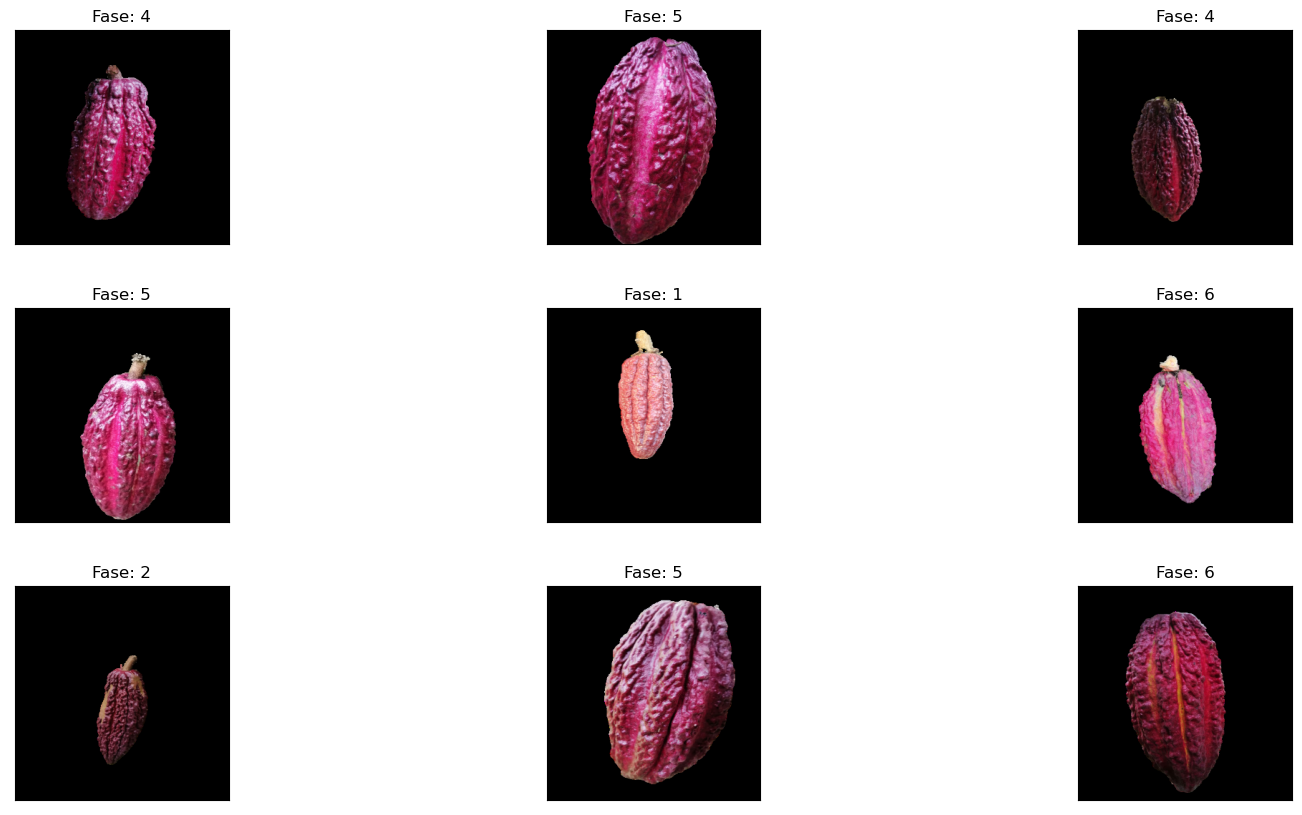

In [11]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Fase: {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

# Prepare data for training the CNN model

In [12]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 1117 1118 1119]

'n' values after shuffling =  [ 874 1071  650 ...  638  348  382]


In [13]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (1120, 299, 299, 3) 
Labels shape after shuffling =  (1120,)


In [14]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (1120, 299, 299, 3)


In [15]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (838, 299, 299, 3)
y_train shape =  (838,)

x_test shape =  (224, 299, 299, 3)
y_test shape =  (224,)

x_val shape =  (58, 299, 299, 3)
y_val shape =  (58,)


In [16]:
##One-hot-encode
y_train = to_categorical(y_train, 7)
y_test = to_categorical(y_test, 7)
y_val = to_categorical(y_val, 7)

# Define CNN model

In [17]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(x_train) 
test_ds = preprocess_input(x_test)

In [18]:
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [19]:
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 7, input_shape = x_train[0].shape, activation='elu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 7, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(32, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 7, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 7, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(64, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 7, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 7, padding='same', activation='elu'),
    ChannelAttention(128, 8),
    SpatialAttention(7),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='sigmoid' )
])

# Train model

In [20]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 9, 9, 32)          802848    
                                                                 
 batch_normalization (BatchN  (None, 9, 9, 32)         128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 32)          50208     
                                                                 
 batch_normalization_1 (Batc  (None, 9, 9, 32)         128       
 hNormalization)                                                 
                                                                 
 channel_attention (ChannelA  (None, 9, 9, 32)         0

In [22]:
steps_per_epoch = (x_train.shape[0]//batch_size)
validation_steps = (x_val.shape[0] // batch_size)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [23]:
x_train.shape,y_train.shape

((838, 299, 299, 3), (838, 7))

In [24]:
start_time = time.time()

history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 50,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)

logging.basicConfig(filename="CNN-basedTL_InceptionV3log.txt", level=logging.INFO)
logging.info("Training Execution Time:" + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

Epoch 1/50
26/26 [==============================] - 280s 11s/step - loss: 2.0745 - acc: 0.1394 - val_loss: 1.9727 - val_acc: 0.1250
Epoch 2/50
26/26 [==============================] - 280s 11s/step - loss: 2.0266 - acc: 0.1526 - val_loss: 1.9308 - val_acc: 0.2812
Epoch 3/50
26/26 [==============================] - 280s 11s/step - loss: 2.0395 - acc: 0.1452 - val_loss: 1.9478 - val_acc: 0.0938
Epoch 4/50
26/26 [==============================] - 279s 11s/step - loss: 2.0096 - acc: 0.1303 - val_loss: 1.9353 - val_acc: 0.2812
Epoch 5/50
26/26 [==============================] - 278s 11s/step - loss: 2.0317 - acc: 0.1352 - val_loss: 1.9116 - val_acc: 0.0312
Epoch 6/50
26/26 [==============================] - 282s 11s/step - loss: 1.7669 - acc: 0.2444 - val_loss: 3.0128 - val_acc: 0.0312
Epoch 7/50
26/26 [==============================] - 277s 11s/step - loss: 1.4680 - acc: 0.3375 - val_loss: 4.2187 - val_acc: 0.2812
Epoch 8/50
26/26 [==============================] - 263s 10s/step - loss: 1.

# Evaluation model

In [25]:
start_time = time.time()

loss, accuracy = model.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

logging.info("Evaluation Execution Time: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss:" + str(loss))
logging.info("test accuracy:" + str(accuracy))

7/7 [==============================] - 61s 9s/step - loss: 19.5624 - acc: 0.1429
test_loss: 1956.24
test_accuracy: 14.29


In [27]:
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
y_pred = model_probs
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_reduced, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 13.84
F1 score: 4.36
Precision: 2.76
Recall: 13.84


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


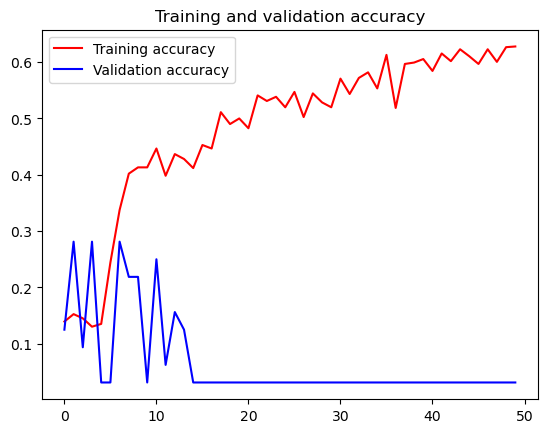

In [28]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-based TL.png")
plt.show() 

In [29]:
Y_pred_classes = np.argmax(y_pred,axis = 1) 

In [30]:
Y_test_classes = np.argmax(y_test,axis = 1) 

In [31]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_test_classes,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion) 

Confusion Matrix

[[29  0  0  0  0  0  0]
 [39  0  0  0  0  0  0]
 [37  0  0  0  0  0  0]
 [31  0  0  2  0  0  0]
 [17  0  0  3  0  0  0]
 [22  0  0  8  0  0  0]
 [ 5  0  0 31  0  0  0]]


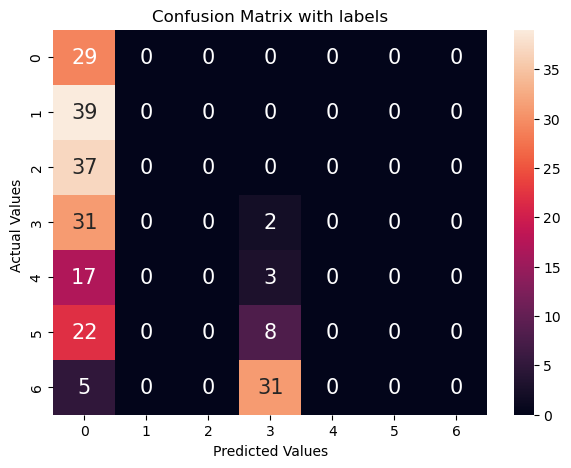

In [32]:
import seaborn as sns
plt.figure(figsize=(7, 5))
plt.xlabel("Preciccion")
plt.ylabel("Actual")
gf = sns.heatmap(confusion, annot=True,  annot_kws={'size': 15}, fmt = "d")
gf.set_title('Confusion Matrix with labels')
gf.set_xlabel('Predicted Values')
gf.set_ylabel('Actual Values ')
plt.show()